In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import shap
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, LassoLars, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import joblib


# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster

C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import skforecast
skforecast.__version__

'0.12.0'

In [3]:
# Function to calculate RMSE and MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

In [33]:
# Download data
# ==============================================================================
# data = fetch_dataset(
#     name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
# )

df = pd.read_csv('data\Data_BIFAST.csv')
data = df.rename(columns={'periode':'datetime', 'nominal_transaksi':'y'})
# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data['datetime'] = data['datetime'].apply(lambda x: x.replace(day=1))
data = data.set_index('datetime')
data = data.resample('MS').asfreq()
data = data[['y']]
data = data.sort_index()
display(data.head())
display(data.info())

,y
datetime,
2021-12-01,1.689177e+12
2022-01-01,3.063191e+13
2022-02-01,4.225941e+13
2022-03-01,6.597968e+13
2022-04-01,1.002110e+14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-12-01 to 2024-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


None

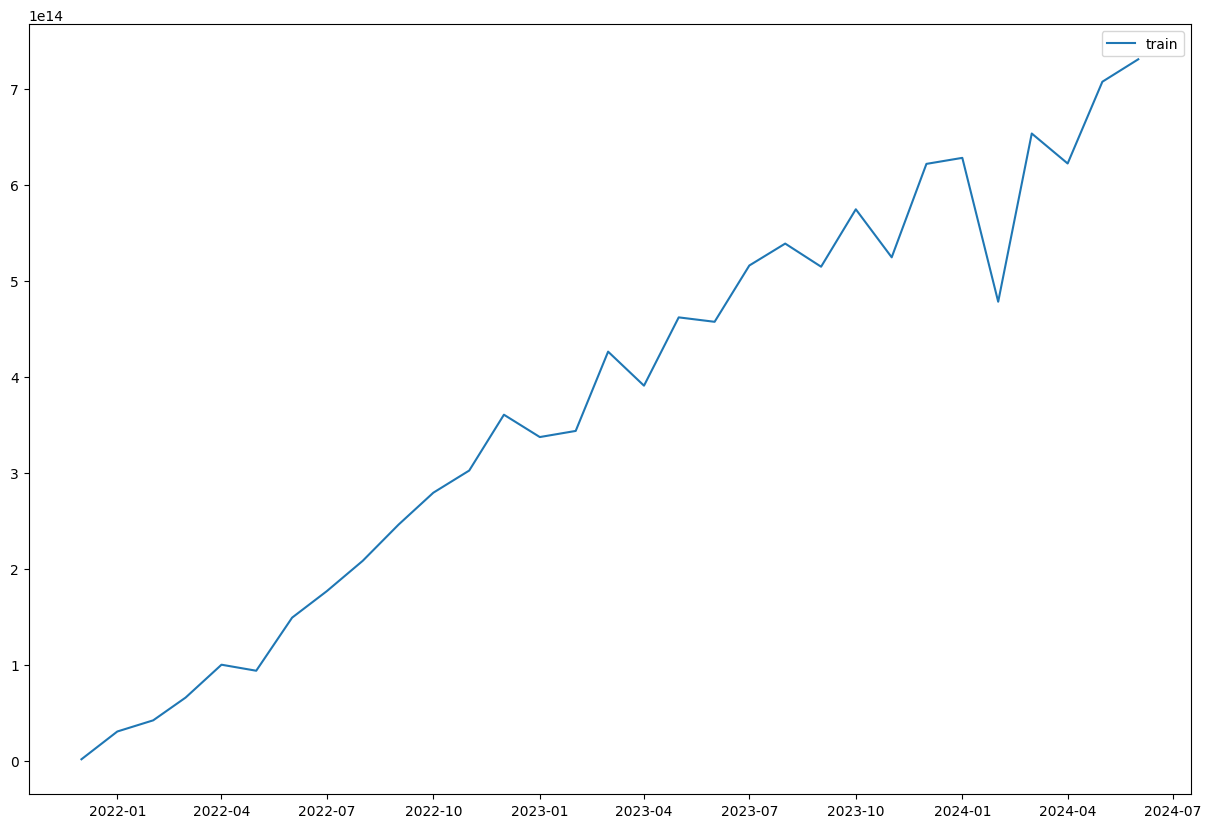

In [34]:

steps = 8

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(data.index, data, label='train')
ax.legend()

In [48]:
int(len(data)*0.99)

30

In [72]:
# Models to compare
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

models = [
    RandomForestRegressor(random_state=123), 
    GradientBoostingRegressor(random_state=123),
    Ridge(random_state=123),
    MLPRegressor(),
    ElasticNet()
]

# Hyperparameter to search for each model
param_grids = {
    'RandomForestRegressor': {'n_estimators': [50, 100], 'max_depth': [5, 15]},
    'GradientBoostingRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10]},
    'Ridge': {'alpha': [0.01, 0.1, 1]},
    'MLP' : {'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'max_iter': [10000],
            'hidden_layer_sizes': [10, 50, 100, 200, 1000],
            'solver': ['adam'],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'early_stopping': [True],
            'learning_rate_init': [0.0001, 0.001, 0.01]},
    'ElasticNet': {'l1_ratio': [0.1, 0.25, 0.5, 1],
                   'max_iter': [1000, 2000, 10000]}
}

# Lags used as predictors
lags_grid = [3]

df_results = pd.DataFrame()
for i, model in enumerate(models):

    print(f"Grid search for regressor: {model}")
    print(f"-------------------------")

    forecaster = ForecasterAutoreg(
                     regressor = model,
                     lags      = 3
                 )

    # Regressor hyperparameters
    param_grid = param_grids[list(param_grids)[i]]

    results = grid_search_forecaster(
                  forecaster         = forecaster,
                  y                  = data['y'],
                  param_grid         = param_grid,
                  lags_grid          = lags_grid,
                  steps              = 24,
                  refit              = True,
                  metric             = 'mean_absolute_percentage_error',
                  initial_train_size = int(len(data)*0.5),
                  fixed_train_size   = True,
                  return_best        = True,
                  n_jobs             = 'auto',
                  verbose            = False,
                  show_progress      = True
              )
    
    # Create a column with model name
    results['model'] = list(param_grids)[i]
    display(results)
    display(param_grid)

    df_results = pd.concat([df_results, results])

df_results = df_results.sort_values(by='mean_absolute_percentage_error')
df_results.head(10)

Grid search for regressor: RandomForestRegressor(random_state=123)
-------------------------
Number of models compared: 4.


lags grid: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.3628965000438249



,lags,lags_label,params,mean_absolute_percentage_error,max_depth,n_estimators,model
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.362897,5,50,RandomForestRegressor
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.362897,15,50,RandomForestRegressor
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.363093,5,100,RandomForestRegressor
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.363093,15,100,RandomForestRegressor


{'n_estimators': [50, 100], 'max_depth': [5, 15]}

Grid search for regressor: GradientBoostingRegressor(random_state=123)
-------------------------
Number of models compared: 4.


lags grid: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.35997930760378327



,lags,lags_label,params,mean_absolute_percentage_error,max_depth,n_estimators,model
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.359979,5,50,GradientBoostingRegressor
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.359979,10,50,GradientBoostingRegressor
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 20}",0.390714,5,20,GradientBoostingRegressor
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 20}",0.390714,10,20,GradientBoostingRegressor


{'n_estimators': [20, 50], 'max_depth': [5, 10]}

Grid search for regressor: Ridge(random_state=123)
-------------------------
Number of models compared: 3.


lags grid: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.10556590911679897



,lags,lags_label,params,mean_absolute_percentage_error,alpha,model
0,"[1, 2, 3]","[1, 2, 3]",{'alpha': 0.01},0.105566,0.01,Ridge
1,"[1, 2, 3]","[1, 2, 3]",{'alpha': 0.1},0.105566,0.10,Ridge
2,"[1, 2, 3]","[1, 2, 3]",{'alpha': 1},0.105566,1.00,Ridge


{'alpha': [0.01, 0.1, 1]}

Grid search for regressor: MLPRegressor()
-------------------------
Number of models compared: 180.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
lags grid: 100%|██████████| 1/1 [01:07<00:00, 67.40s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': 1000, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 10000, 'solver': 'adam'}
  Backtesting metric: 0.09031423536357885



,lags,lags_label,params,mean_absolute_percentage_error,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_iter,solver,model
179,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.090314,relu,True,1000,adaptive,0.0100,10000,adam,MLP
15,"[1, 2, 3]","[1, 2, 3]","{'activation': 'identity', 'early_stopping': T...",0.091534,identity,True,50,adaptive,0.0001,10000,adam,MLP
165,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.092974,relu,True,200,invscaling,0.0001,10000,adam,MLP
153,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.094574,relu,True,100,constant,0.0001,10000,adam,MLP
177,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.099598,relu,True,1000,adaptive,0.0001,10000,adam,MLP
...,...,...,...,...,...,...,...,...,...,...,...,...
158,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",5.529576,relu,True,100,invscaling,0.0100,10000,adam,MLP
41,"[1, 2, 3]","[1, 2, 3]","{'activation': 'identity', 'early_stopping': T...",8.005624,identity,True,1000,invscaling,0.0100,10000,adam,MLP
40,"[1, 2, 3]","[1, 2, 3]","{'activation': 'identity', 'early_stopping': T...",8.312653,identity,True,1000,invscaling,0.0010,10000,adam,MLP
14,"[1, 2, 3]","[1, 2, 3]","{'activation': 'identity', 'early_stopping': T...",8.776872,identity,True,50,invscaling,0.0100,10000,adam,MLP


{'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'max_iter': [10000],
 'hidden_layer_sizes': [10, 50, 100, 200, 1000],
 'solver': ['adam'],
 'learning_rate': ['constant', 'invscaling', 'adaptive'],
 'early_stopping': [True],
 'learning_rate_init': [0.0001, 0.001, 0.01]}

Grid search for regressor: ElasticNet()
-------------------------
Number of models compared: 12.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e+27, tolerance: 1.208e+25
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e+27, tolerance: 1.208e+25
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'l1_ratio': 0.1, 'max_iter': 1000}
  Backtesting metric: 0.10556590908947688




C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.293e+28, tolerance: 1.023e+26
  model = cd_fast.enet_coordinate_descent(


,lags,lags_label,params,mean_absolute_percentage_error,l1_ratio,max_iter,model
0,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.1, 'max_iter': 1000}",0.105566,0.10,1000.0,ElasticNet
3,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.25, 'max_iter': 1000}",0.105566,0.25,1000.0,ElasticNet
6,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.5, 'max_iter': 1000}",0.105566,0.50,1000.0,ElasticNet
9,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 1, 'max_iter': 1000}",0.105566,1.00,1000.0,ElasticNet
1,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.1, 'max_iter': 2000}",0.105566,0.10,2000.0,ElasticNet
2,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.1, 'max_iter': 10000}",0.105566,0.10,10000.0,ElasticNet
4,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.25, 'max_iter': 2000}",0.105566,0.25,2000.0,ElasticNet
5,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.25, 'max_iter': 10000}",0.105566,0.25,10000.0,ElasticNet
7,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.5, 'max_iter': 2000}",0.105566,0.50,2000.0,ElasticNet
8,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.5, 'max_iter': 10000}",0.105566,0.50,10000.0,ElasticNet


{'l1_ratio': [0.1, 0.25, 0.5, 1], 'max_iter': [1000, 2000, 10000]}

,lags,lags_label,params,mean_absolute_percentage_error,max_depth,n_estimators,model,alpha,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_iter,solver,l1_ratio
179,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.090314,NaN,NaN,MLP,NaN,relu,True,1000.0,adaptive,0.0100,10000.0,adam,NaN
15,"[1, 2, 3]","[1, 2, 3]","{'activation': 'identity', 'early_stopping': T...",0.091534,NaN,NaN,MLP,NaN,identity,True,50.0,adaptive,0.0001,10000.0,adam,NaN
165,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.092974,NaN,NaN,MLP,NaN,relu,True,200.0,invscaling,0.0001,10000.0,adam,NaN
153,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.094574,NaN,NaN,MLP,NaN,relu,True,100.0,constant,0.0001,10000.0,adam,NaN
177,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.099598,NaN,NaN,MLP,NaN,relu,True,1000.0,adaptive,0.0001,10000.0,adam,NaN
172,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.100557,NaN,NaN,MLP,NaN,relu,True,1000.0,constant,0.0010,10000.0,adam,NaN
146,"[1, 2, 3]","[1, 2, 3]","{'activation': 'relu', 'early_stopping': True,...",0.105435,NaN,NaN,MLP,NaN,relu,True,50.0,constant,0.0100,10000.0,adam,NaN
3,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.25, 'max_iter': 1000}",0.105566,NaN,NaN,ElasticNet,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.25
6,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 0.5, 'max_iter': 1000}",0.105566,NaN,NaN,ElasticNet,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,0.50
9,"[1, 2, 3]","[1, 2, 3]","{'l1_ratio': 1, 'max_iter': 1000}",0.105566,NaN,NaN,ElasticNet,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,1.00


In [61]:
df_results.iloc[0]

lags                                                                      [1, 2, 3]
lags_label                                                                [1, 2, 3]
params                            {'activation': 'identity', 'early_stopping': T...
mean_absolute_percentage_error                                             0.082032
max_depth                                                                       NaN
n_estimators                                                                    NaN
model                                                                           MLP
alpha                                                                           NaN
activation                                                                 identity
early_stopping                                                                 True
hidden_layer_sizes                                                             10.0
learning_rate                                                            inv

In [62]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(regressor = MLPRegressor(activation='identity', 
                                                        early_stopping=True, hidden_layer_sizes=10, 
                                                        learning_rate='invscaling', 
                                                        learning_rate_init=0.0001, max_iter=10000, solver='adam'), lags = 3)
forecaster.fit(y=data['y'])

In [63]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=24)
last_date = data['y'].index[-1]
future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]
predictions.index = future_dates
predictions

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_18624\2041216415.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]


2024-07-31    7.188246e+14
2024-08-31    7.180034e+14
2024-09-30    7.083292e+14
2024-10-31    7.041273e+14
2024-11-30    6.964894e+14
2024-12-31    6.911280e+14
2025-01-31    6.844058e+14
2025-02-28    6.786415e+14
2025-03-31    6.723564e+14
2025-04-30    6.664922e+14
2025-05-31    6.604479e+14
2025-06-30    6.546058e+14
2025-07-31    6.487214e+14
2025-08-31    6.429498e+14
2025-09-30    6.371913e+14
2025-10-31    6.315088e+14
2025-11-30    6.258614e+14
2025-12-31    6.202744e+14
2026-01-31    6.147310e+14
2026-02-28    6.092412e+14
2026-03-31    6.037978e+14
2026-04-30    5.984047e+14
2026-05-31    5.930587e+14
2026-06-30    5.877612e+14
Freq: ME, Name: pred, dtype: float64

In [64]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data['y'])

# Predict using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
len(predictions_training)

28

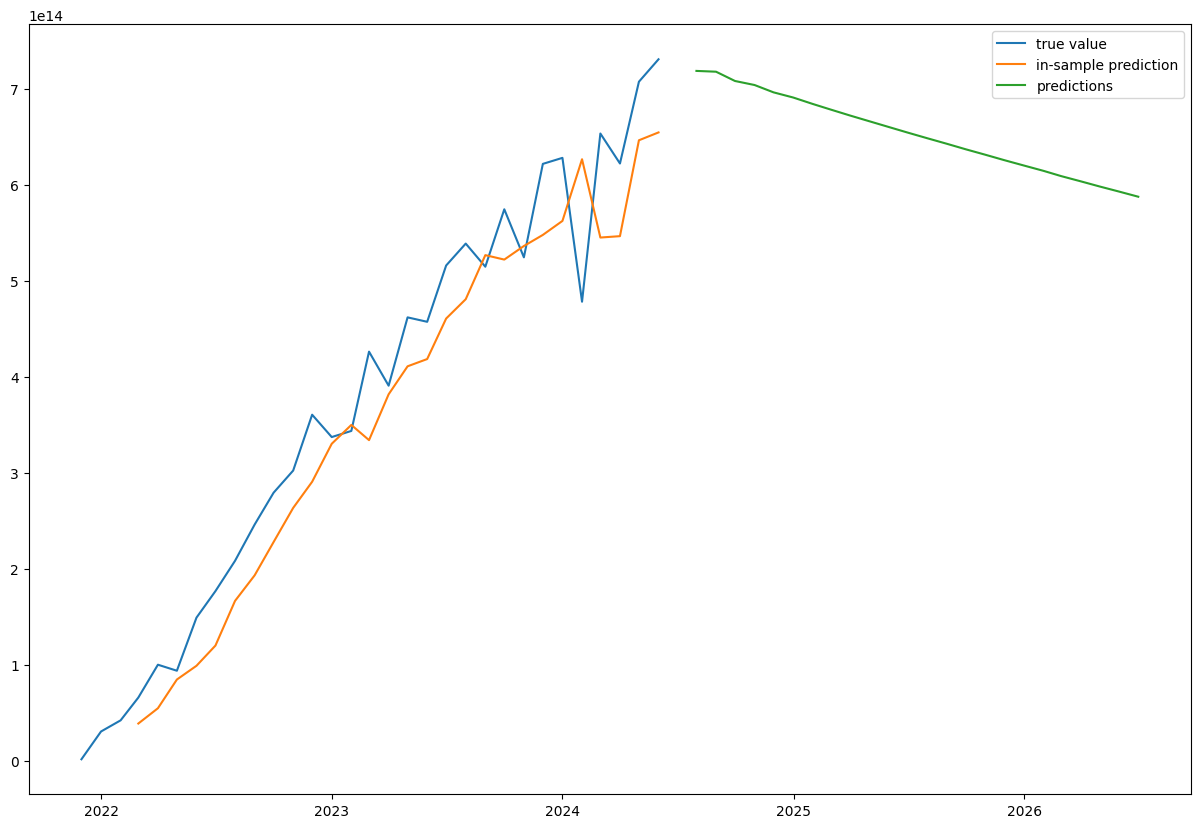

In [65]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(data['y'].index, data['y'], label='true value')
# data_test.plot(ax=ax, label='test')
# pd.Series(predictions_training, index=data.index[3:]).plot(ax=ax, label='insample predictions')
plt.plot(data['y'].index[3:], predictions_training, label='in-sample prediction')
plt.plot(predictions.index, predictions, label='predictions')
ax.legend()